In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing

Ilya Tsuprun KA-14mp
Task No 26

# Multivariate and Univariate polinomical regression and mini-batch gradient descent

# Input data

## Dataset 1 (Univariate)

In [2]:
def make_data(N, err = 1.0, rseed = 1):
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1./ (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(200)

In [3]:
print("X-array shape: ", X.shape)
print("y-array shape: ", y.shape)

X-array shape:  (200, 1)
y-array shape:  (200,)


## Dataset 2 (Multivariate)

In [4]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
X2 = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y2 = california_housing.target

In [5]:
X2.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -121.800000  
50%        2.818116     34.260000   -118.490000  
75%        3.282261     37.710000   -118.010000  
max     1243.333333     41.950000   -114.310000

In [6]:
X2 = X2.values
print("Features shape: ", X2.shape)
print("Labels shape: ", y2.shape)

Features shape:  (20640, 8)
Labels shape:  (20640,)


# Data visualization

## Dataset 1

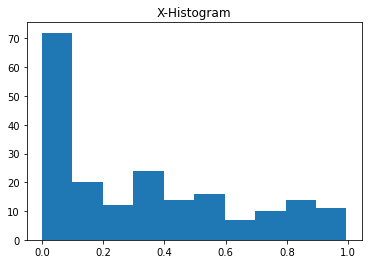

In [7]:
# histogram of X
plt.hist(X)
plt.title("X-Histogram")
plt.show()

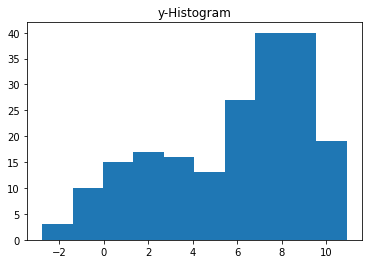

In [8]:
# histogram of y
plt.hist(y)
plt.title("y-Histogram")
plt.show()

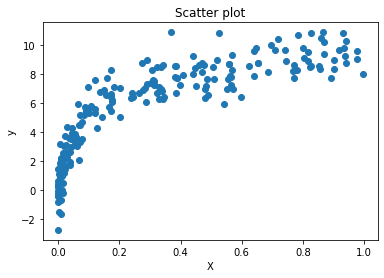

In [9]:
def print_scatter_plot(X, y, title, xlabel, ylabel):
    plt.scatter(X, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
print_scatter_plot(X, y, "Scatter plot", "X", "y")

#### Based on the visualization of the data, for their best approximation, we need a polynomial of odd degree, so I took a polynomial of the 3rd degree
#### Then in the case of one feature, our model takes the following form:
#### y = ax^3 + bx^2 + cx + d

## Dataset 2

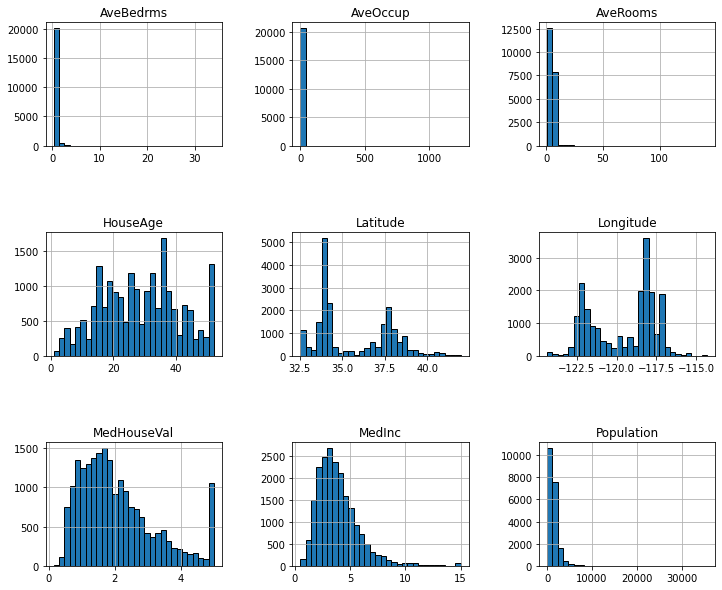

In [10]:
california_housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

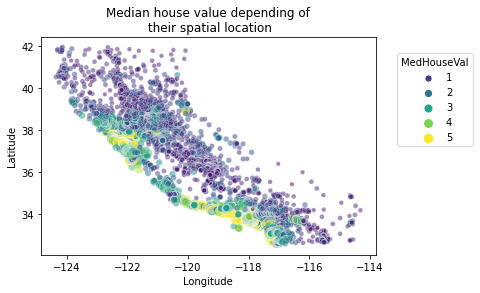

In [11]:
import seaborn as sns

sns.scatterplot(data=california_housing.frame, x="Longitude", y="Latitude",
                size="MedHouseVal", hue="MedHouseVal",
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

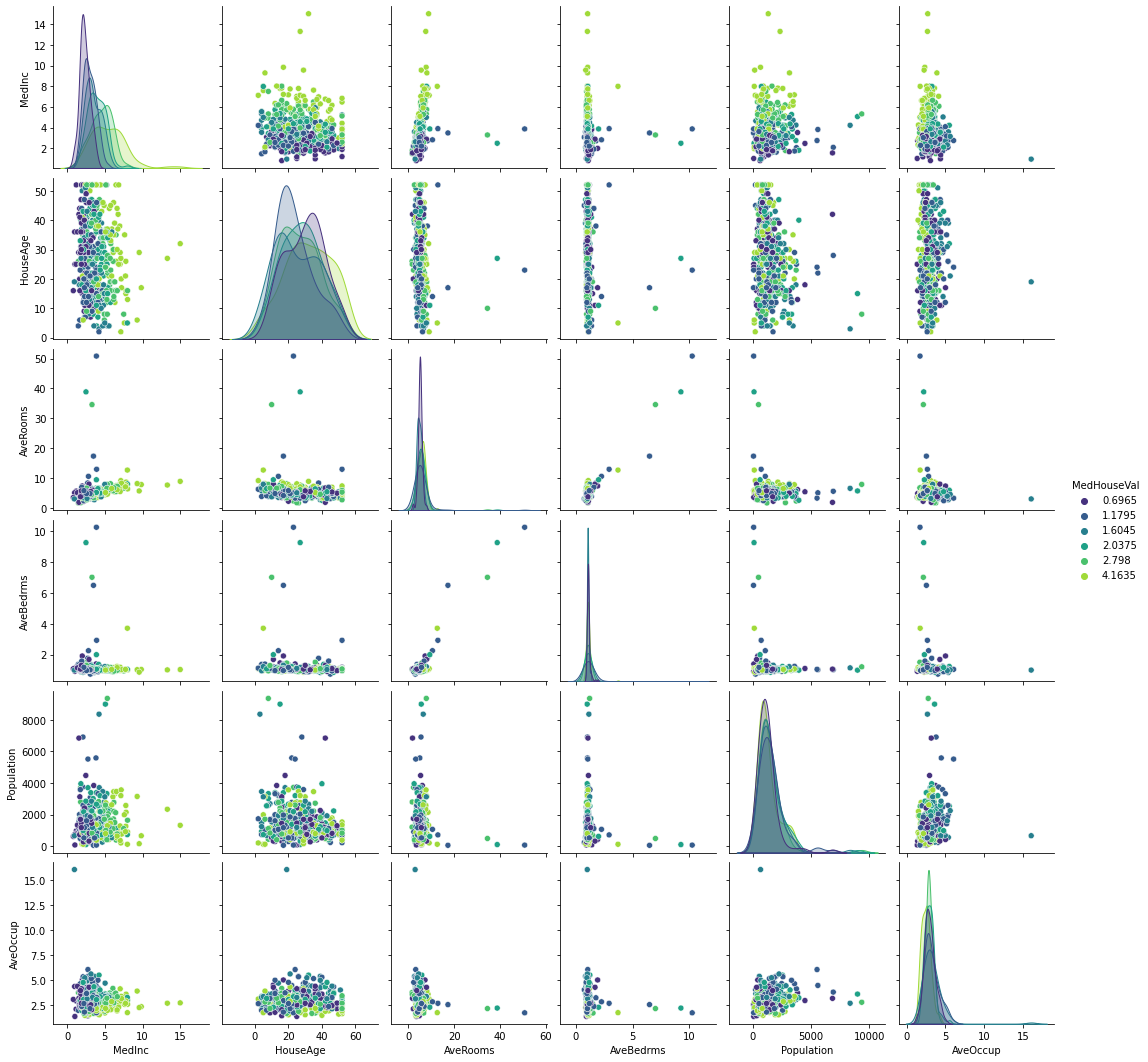

In [12]:
import pandas as pd


rng = np.random.RandomState(0)
indices = rng.choice(np.arange(california_housing.frame.shape[0]), size=500,
                     replace=False)
# Drop the unwanted columns
columns_drop = ["Longitude", "Latitude"]
subset = california_housing.frame.iloc[indices].drop(columns=columns_drop)
# Quantize the target and keep the midpoint for each interval
subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)
subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)
_ = sns.pairplot(data=subset, hue="MedHouseVal", palette="viridis")

# Data transformation (degrees terms calculation)

In the case when we have 2+ features, that is, a multivariate polynomial regression, it is necessary to calculate the terms of the polynomial for each degree.

So, data transformation here is used to calculate polynomial terms for each degree. 

For instance, the degree 2 model is of the form:

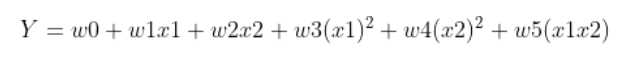

transform_data(X, 2) will calculate x1, x2, x1^2, x2^2, x1x2

To simplify further calculations, let assume that w0 = wo * x0 = w0 * 1, so x0 = 1. The concatenate_ones() function append ones vector to X

In [13]:
from itertools import combinations_with_replacement

def get_powers(n_features, degree):
    l = np.arange(n_features)
    powers=[]
    for i in range(1,degree+1):
        powers.append([x for x in combinations_with_replacement(l,i)])
    powers_flattened=[]
    for sublist in powers:
        for x in sublist:
            powers_flattened.append(x)
    return powers_flattened


def transform_data(X,powers):
    X_new=np.ones((X.shape[0],len(powers)))
    for n in range(X.shape[0]):
        for i in range(len(powers)):
            for j in powers[i]:
                X_new[n][i]=X_new[n][i]*X[n][j]
    return X_new

def concatenate_ones(X):
    ones=np.ones((X.shape[0],1))
    X=np.concatenate((ones,X),axis=1) 
    return X

## Dataset 1

In [14]:
powers = get_powers(1,3)
powers

[(0,), (0, 0), (0, 0, 0)]

In [15]:
X.shape

(200, 1)

In [16]:
X = transform_data(X, powers)
X = concatenate_ones(X)
y = y.reshape(-1, 1)

## Dataset 2

#### Data normalization

#### Polinomial terms calculation

In [17]:
X2 = preprocessing.normalize(X2, axis = 0)
y2 = y2.values.reshape(-1, 1)
y2 = preprocessing.normalize(y2, axis = 0)

In [18]:
powers = get_powers(8,3)

In [19]:
X2 = transform_data(X2, powers)
X2 = concatenate_ones(X2)

In [20]:
X2.shape

(20640, 165)

# Set initial parameters vector

In [21]:
# parameters vector, [a, b, c, d]
def create_initial_theta(X):
    return np.ones((1,X.shape[1]))

theta=create_initial_theta(X)
print("Dataset1 initial parameters vector: \n", theta)

theta2=create_initial_theta(X2)
print("Dataset2 initial parameters vector: \n", theta2)

Dataset1 initial parameters vector: 
 [[1. 1. 1. 1.]]
Dataset2 initial parameters vector: 
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


# Realize model function (predict function)

In [22]:
def predicted(X,theta):
    return (X@(np.transpose(theta)))

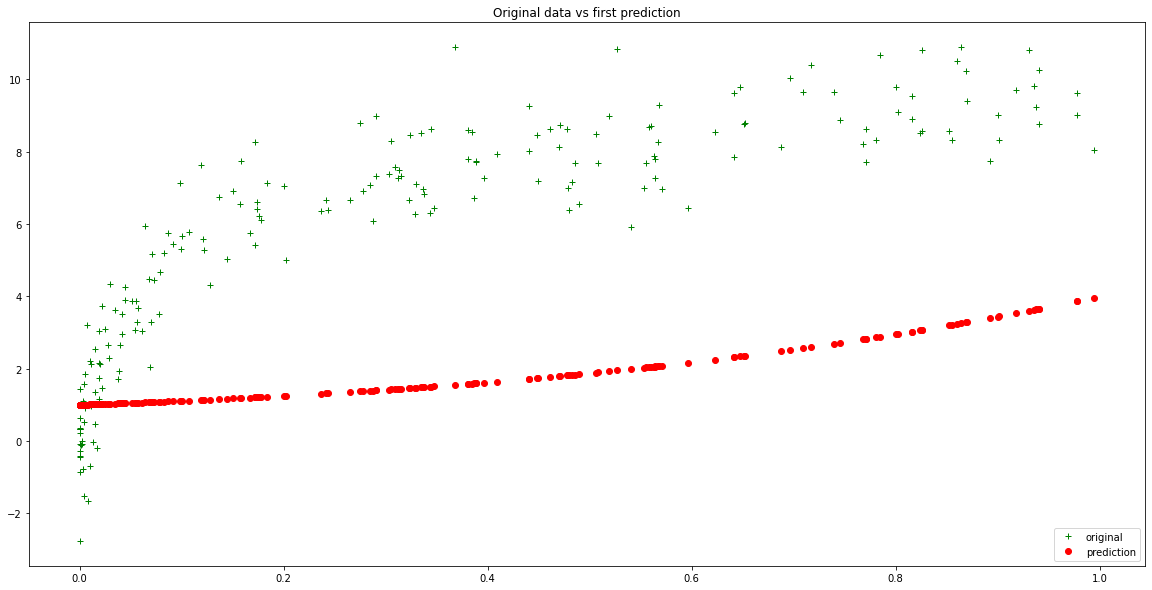

In [23]:
# Initial model value
y_pred_initial = predicted(X, theta)


plt.figure(figsize=(20,10))
plt.plot(X[:, 1], y, 'g+', label = 'original')
plt.plot(X[:, 1], y_pred_initial, 'ro', label='prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

In [24]:
y2_pred_initial = predicted(X2, theta2)

# Loss function (MSE with L2 regularization)

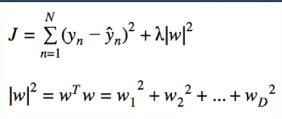

In [25]:
# loss function (will be minimized while training with mini-batch gradient descent)
def loss_mse_l2(y_true, y_pred, lambda_):
    w = np.sum(theta**2, axis = 1)
    return (sum((y_true - y_pred)**2) / len(y_true)) + lambda_*w

In [26]:
# Dataset1 initial model loss
initial_model_loss = loss_mse_l2(y, y_pred_initial, 0.001)  
print("Dataset1 initial model loss: ", initial_model_loss)

# Dataset1 initial model loss
initial_model_loss2 = loss_mse_l2(y2, y2_pred_initial, 0.0000001)  
print("Dataset2 initial model loss: ", initial_model_loss2)

Dataset1 initial model loss:  [24.76227722]
Dataset2 initial model loss:  [1.05607991]


# Implementing mini batch gradient descent

Let theta = model parameters and max_iters = number of epochs.

for itr = 1, 2, 3, …, max_iters:
      for mini_batch (X_mini, y_mini):

    Forward Pass on the batch X_mini:
        - Make predictions on the mini-batch
        - Compute error in predictions (J(theta)) with the current values of the parameters
    Backward Pass:
        Compute gradient(theta) = partial derivative of J(theta) w.r.t. theta
    Update parameters:
        theta = theta – learning_rate*gradient(theta)

In [27]:
# function to create a list containing mini-batches
def create_mini_batches(X, y, batch_size):
    mini_batches = []
    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    i = 0
  
    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches

def mini_batch_gradient_descent_with_L2_regularisation(X, y, theta, batch_size, learning_rate, iterations, lambda_):
    continuous_loss_history = []
    epoch_loss_history = []
    
    for i in range(iterations):
        # Creating mini-batches
        mini_batches = create_mini_batches(X, y, batch_size)
        for mini_batch in mini_batches[:-2]:
            X_batch = mini_batch[0]
            y_batch_true = mini_batch[1]
            y_batch_pred = predicted(X_batch,theta)
            
            #print(theta)
            # Gradient value with respect to each parameter calculation
            gradient_w_r_t_weights = 2*np.sum(X_batch * ((y_batch_pred - y_batch_true)), axis=0)/X_batch.shape[0] + 2*lambda_*theta
            # Updating theta taking the learning rate into account
            theta = theta - (learning_rate) * gradient_w_r_t_weights
            # Writing error on the mini batch to the history
            #continuous_loss_history.append(loss_mse_l2(y_batch_true, y_batch_pred, lambda_))
        
        #print(theta)
        
        # Creating control point with theta
        # Can be used as new initial parameters for training after unexpected stop
        if i % 10 == 0:
            pd.DataFrame(theta).to_csv('control_point.csv')
        
        # Calculating error for current epoch
        y_pred = predicted(X, theta)
        epoch_loss_history.append(loss_mse_l2(y, y_pred, lambda_))
    
    #Saving final weights
    pd.DataFrame(theta).to_csv('control_point.csv')
    return theta, epoch_loss_history

# Model training, evaluation, hyperparameters research

In [28]:
def train_and_evaluate(X,y,learning_rate,iterations,degree, lambda_, batch_size, print_loss = True):
    # creating initial parameters vector
    theta=create_initial_theta(X)
    # Train - test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    # training with mini_batch gradient_descent
    final_weights, epoch_loss_history = mini_batch_gradient_descent_with_L2_regularisation(X_train, y_train, theta, batch_size, learning_rate, iterations, lambda_)

    mse_l2_test = loss_mse_l2(y_test, predicted(X_test, final_weights), lambda_)

    if print_loss:
        print("Weights: "+str(final_weights))
        print("mse_l2 for testing dataset: "+str(mse_l2_test))
        
    return final_weights, mse_l2_test, epoch_loss_history

In [29]:
def plot_loss_curve_each_n_epochs(epoch_loss_history, n, title = None):
    iterations = len(epoch_loss_history)
    temp=np.arange(iterations, step = n)
    each_n_epoch_loss_history = epoch_loss_history[0::n]
    
    plt.plot(temp,each_n_epoch_loss_history,label='training error')

    plt.xlabel("Iterations")
    plt.ylabel("Error")
    if title:
        plt.title(title)
    else:
        plt.title(("Training Error for regression model of degree "+str(degree)))
    plt.legend( loc='upper left')


    plt.show()
    plt.close()

## Dataset 1

### First steps..

Weights: [[ 1.9382093  17.65725755 -6.98447684 -4.23055109]]
mse_l2 for testing dataset: [2.10877326]


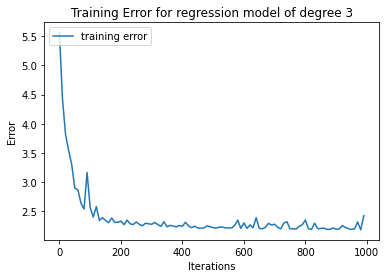

In [30]:
# Setting up training params
learning_rate = 0.5
iterations = 1000
degree = 3
lambda_ = 0.001
batch_size = 50

final_weights, mse_l2_test, loss_history = train_and_evaluate(X,y,learning_rate,iterations,degree, lambda_, batch_size)
plot_loss_curve_each_n_epochs(loss_history, 10)

### Learning rate and mini-batch size hyperparams training

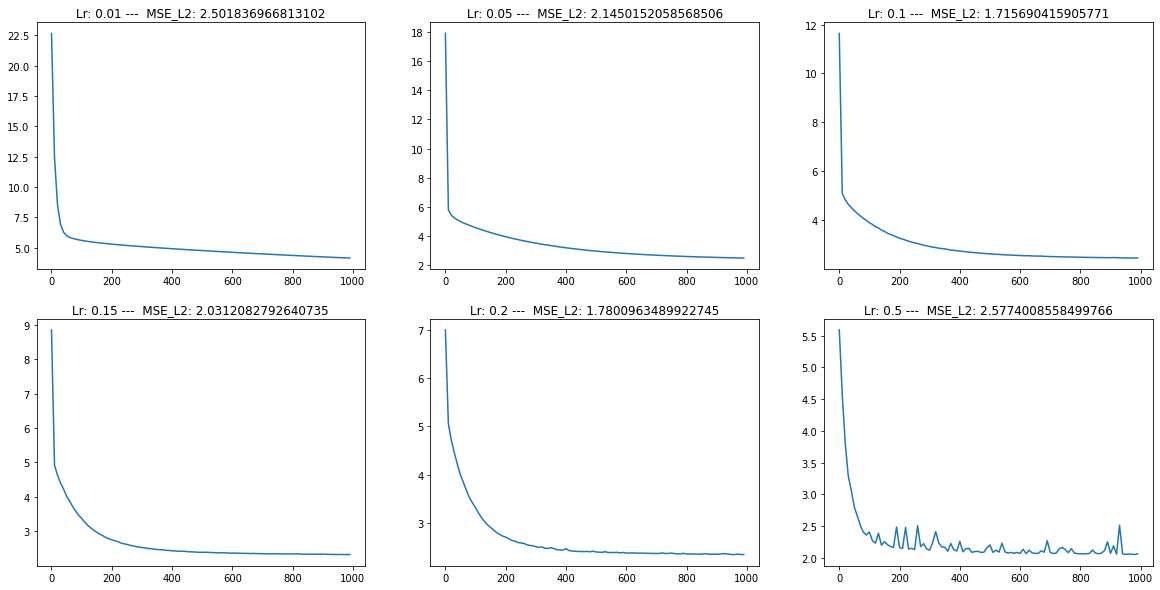

In [31]:
learning_rate_vals = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.5])

## Learning rate training
fig, axs = plt.subplots(2, 3, figsize = (20, 10))
i,j = 0,0
for learning_rate in learning_rate_vals:
    final_weights, mse_l2_test, loss_history = train_and_evaluate(X,y,learning_rate,iterations,degree, lambda_, batch_size, print_loss = False)
    temp = np.arange(1000, step = 10)
    axs[i][j].plot(temp, loss_history[0::10])
    axs[i][j].set_title("Lr: %s ---  MSE_L2: %s" % (learning_rate, mse_l2_test[0]))
    j+=1
    if j%3==0:
        i+=1
        j=0

#### The best loss value was obtained with a learning rate of 0.1. 
#### Obviously, the higher the learning rate, the faster the error drops. However, it can be seen that the learning curve becomes less smooth as the learning rate increases. This is probably due to a stronger response to a large number of weakly informative batches at some iterations.

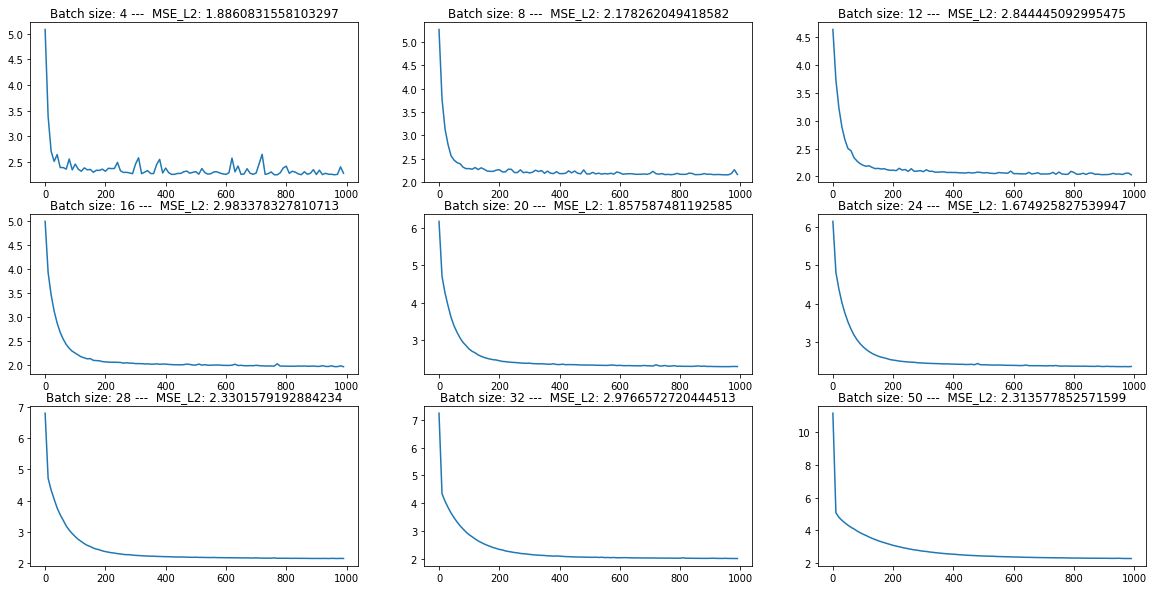

In [32]:
learning_rate = 0.1
batch_size_vals = np.array([4, 8, 12, 16, 20, 24, 28, 32, 50])

## Learning rate training
fig, axs = plt.subplots(3, 3, figsize = (20, 10))
i,j = 0,0
for batch_size in batch_size_vals:
    final_weights, mse_l2_test, loss_history = train_and_evaluate(X,y,learning_rate,iterations,degree, lambda_, batch_size, print_loss = False)
    temp = np.arange(1000, step = 10)
    axs[i][j].plot(temp, loss_history[0::10])
    axs[i][j].set_title("Batch size: %s ---  MSE_L2: %s" % (batch_size, mse_l2_test[0]))
    j+=1
    if j%3==0:
        i+=1
        j=0

#### It is worth noting here that the loss curve becomes smoother as the batch size increases. 
#### However, given the sample size of 200 samples, it is difficult to find a pattern in terms of better batten size. 
#### The smallest error was achieved with a batch size of 8, but any other batch size also performed well.

### Regularization parameter research

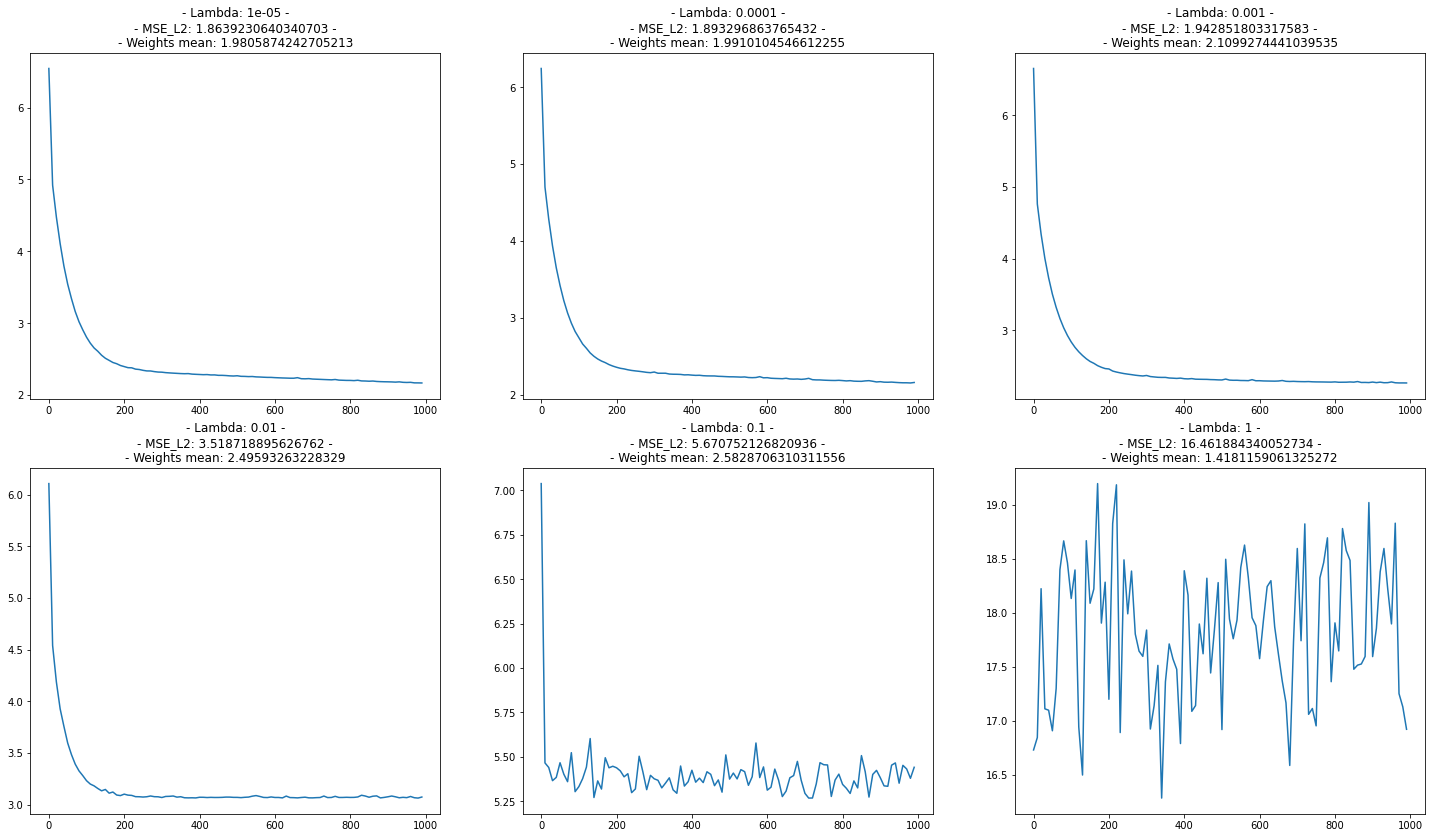

In [34]:
# Setting up training params
learning_rate = 0.1
batch_size = 24
lambda_vals = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

## Learning rate training
fig, axs = plt.subplots(2, 3, figsize = (25, 14))
i,j = 0,0
best_lr = 0.01
for lambda_ in lambda_vals:
    final_weights, mse_l2_test, loss_history = train_and_evaluate(X,y,learning_rate,iterations,degree, lambda_, batch_size, print_loss = False)
    temp = np.arange(1000, step = 10)
    axs[i][j].plot(temp, loss_history[0::10])
    axs[i][j].set_title("- Lambda: %s -\n- MSE_L2: %s -\n- Weights mean: %s" % (lambda_, mse_l2_test[0], final_weights.mean()))
    j+=1
    if j%3==0:
        i+=1
        j=0

#### By examining the regularization parameter, I can conclude that the best model result is achieved when the value of the parameter is 1e-05

### Best model

Weights: [[  1.89195234  19.55612367 -10.5249276   -2.72553122]]
mse_l2 for testing dataset: [1.44536201]


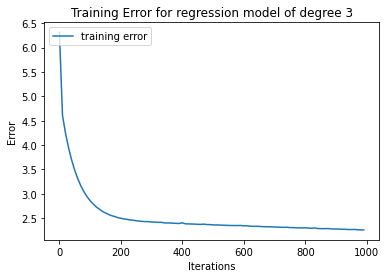

In [35]:
# Setting up training params
learning_rate = 0.1
iterations = 1000
degree = 3
lambda_ = 0.00001
batch_size = 24

final_weights, mse_l2_test, loss_history = train_and_evaluate(X,y,learning_rate,iterations,degree, lambda_, batch_size)
plot_loss_curve_each_n_epochs(loss_history, 10)

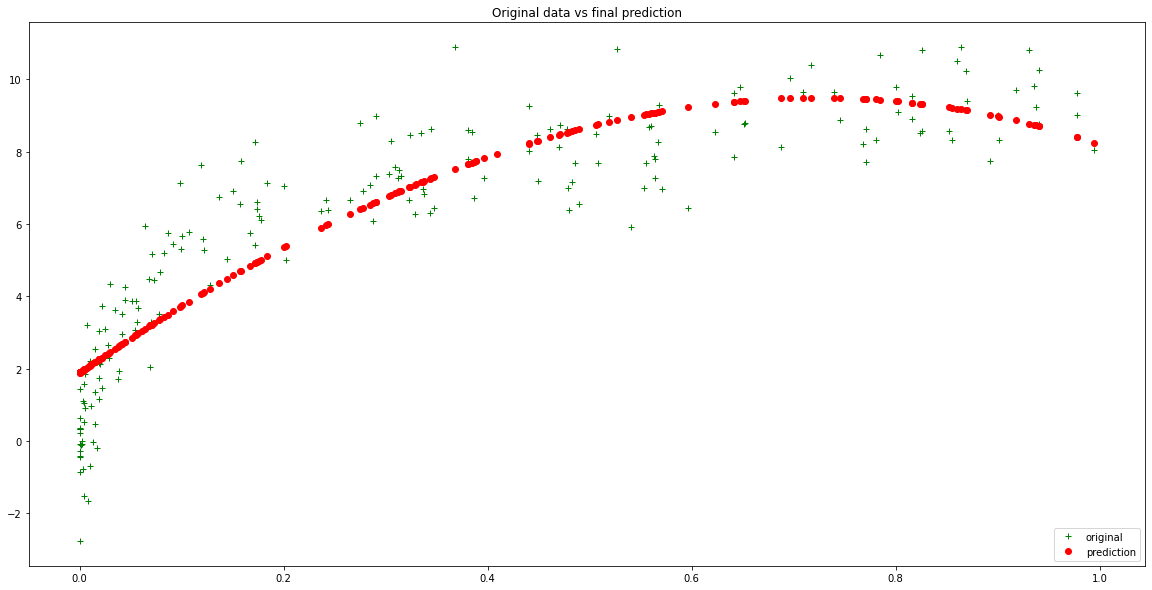

In [36]:
y_pred = predicted(X, final_weights)


plt.figure(figsize=(20,10))
plt.plot(X[:, 1], y, 'g+', label = 'original')
plt.plot(X[:, 1], y_pred, 'ro', label='prediction')
plt.title('Original data vs final prediction')
plt.legend(loc="lower right")
plt.show()

## Dataset 2

### First steps..

Weights: [[-0.00890856  0.79709849  0.80596505  0.36036384  0.46707478  0.35444356
  -0.28757911  0.96069729  1.00047481  0.98740707  0.98904494  0.98645104
   0.98750312  0.98569989  0.97068244  0.9898677   0.99270831  0.98881584
   0.98737265  0.98797226  0.98796153  0.97833658  0.98989628  0.99265596
   0.9636355   0.96290399  0.98612949  0.98529645  0.98663066  0.99573652
   0.96130294  0.9870064   0.98421937  0.98734088  0.99499577  0.97221582
   0.95459858  0.98687068  0.99577139  0.01808012  0.98179664  1.00041836
   0.99096096  0.99157253  0.99126488  0.99126671  0.99130752  0.99128812
   0.99130358  0.99128387  0.99100608  0.99131558  0.99137119  0.99131886
   0.99131214  0.99131904  0.99131438  0.99113693  0.99132685  0.99135983
   0.9911868   0.991192    0.99129904  0.99125809  0.99130794  0.99137777
   0.99119074  0.99130722  0.99123793  0.9913151   0.99137046  0.99118556
   0.99075976  0.99130417  0.99138295  0.975407    0.99118959  0.99149029
   0.9913325   0.99135405  0.

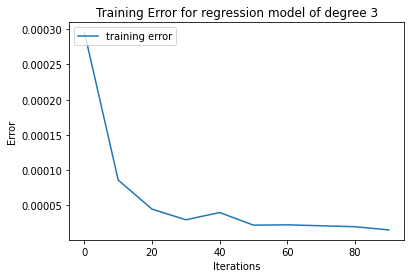

In [37]:
# Setting up training params
learning_rate = 0.9
iterations = 100
degree = 3
lambda_ = 0.0000001
batch_size = 32
final_weights, mse_l2_test, loss_history = train_and_evaluate(X2,y2,learning_rate,iterations,degree, lambda_, batch_size)
plot_loss_curve_each_n_epochs(loss_history, 10)

### Learning rate and mini-batch size hyperparams training

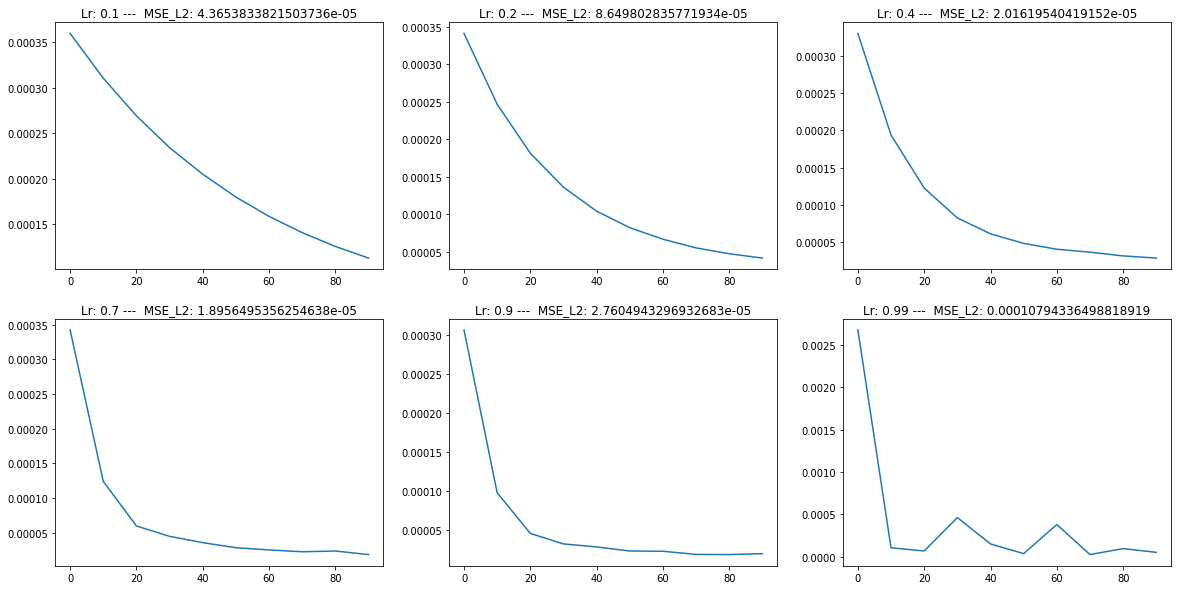

In [38]:
learning_rate_vals = np.array([0.1, 0.2, 0.4, 0.7, 0.9, 0.99])

## Learning rate training
fig, axs = plt.subplots(2, 3, figsize = (20, 10))
i,j = 0,0
for learning_rate in learning_rate_vals:
    final_weights, mse_l2_test, loss_history = train_and_evaluate(X2,y2,learning_rate,iterations,degree, lambda_, batch_size, print_loss = False)
    temp = np.arange(100, step = 10)
    axs[i][j].plot(temp, loss_history[0::10])
    axs[i][j].set_title("Lr: %s ---  MSE_L2: %s" % (learning_rate, mse_l2_test[0]))
    j+=1
    if j%3==0:
        i+=1
        j=0

#### The best loss value was obtained with a learning rate of 0.7. 
#### Here we can see that the error begins to fall faster for a higher learning rate. However, if we increase the learning rate more than 0.7, the resulting error is larger. Most likely the model is over-trained at a given number of iterations.

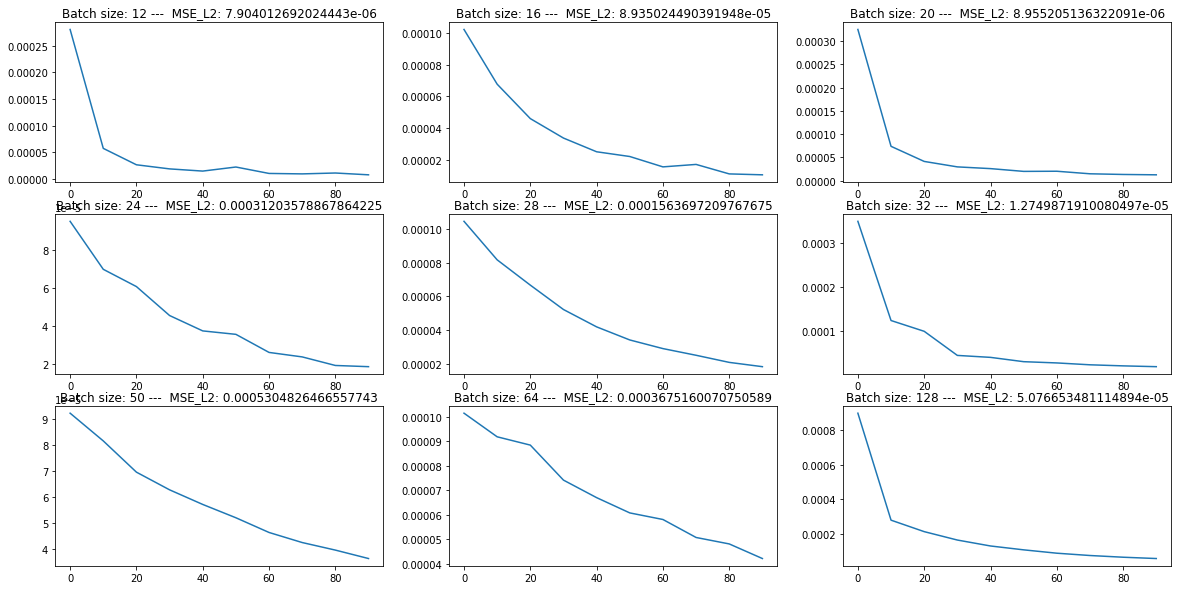

In [39]:
learning_rate = 0.7
batch_size_vals = np.array([12, 16, 20, 24, 28, 32, 50, 64, 128])

## Learning rate training
fig, axs = plt.subplots(3, 3, figsize = (20, 10))
i,j = 0,0
for batch_size in batch_size_vals:
    final_weights, mse_l2_test, loss_history = train_and_evaluate(X2,y2,learning_rate,iterations,degree, lambda_, batch_size, print_loss = False)
    temp = np.arange(100, step = 10)
    axs[i][j].plot(temp, loss_history[0::10])
    axs[i][j].set_title("Batch size: %s ---  MSE_L2: %s" % (batch_size, mse_l2_test[0]))
    j+=1
    if j%3==0:
        i+=1
        j=0

#### Based on the loss curve plots, we can see that the error drops slower when the batches are larger. 
#### For example, with a batch size of 12-20 the error reached the value about 0.00005 at the 20th iteration, while with a batch size of 128 the error was 0.0001-0.0002.
#### The smallest error at the last iteration was achieved with a batch size of 12, but a batch size of 16, 20, 32 and 128 also performed well.

### Regularization parameter research

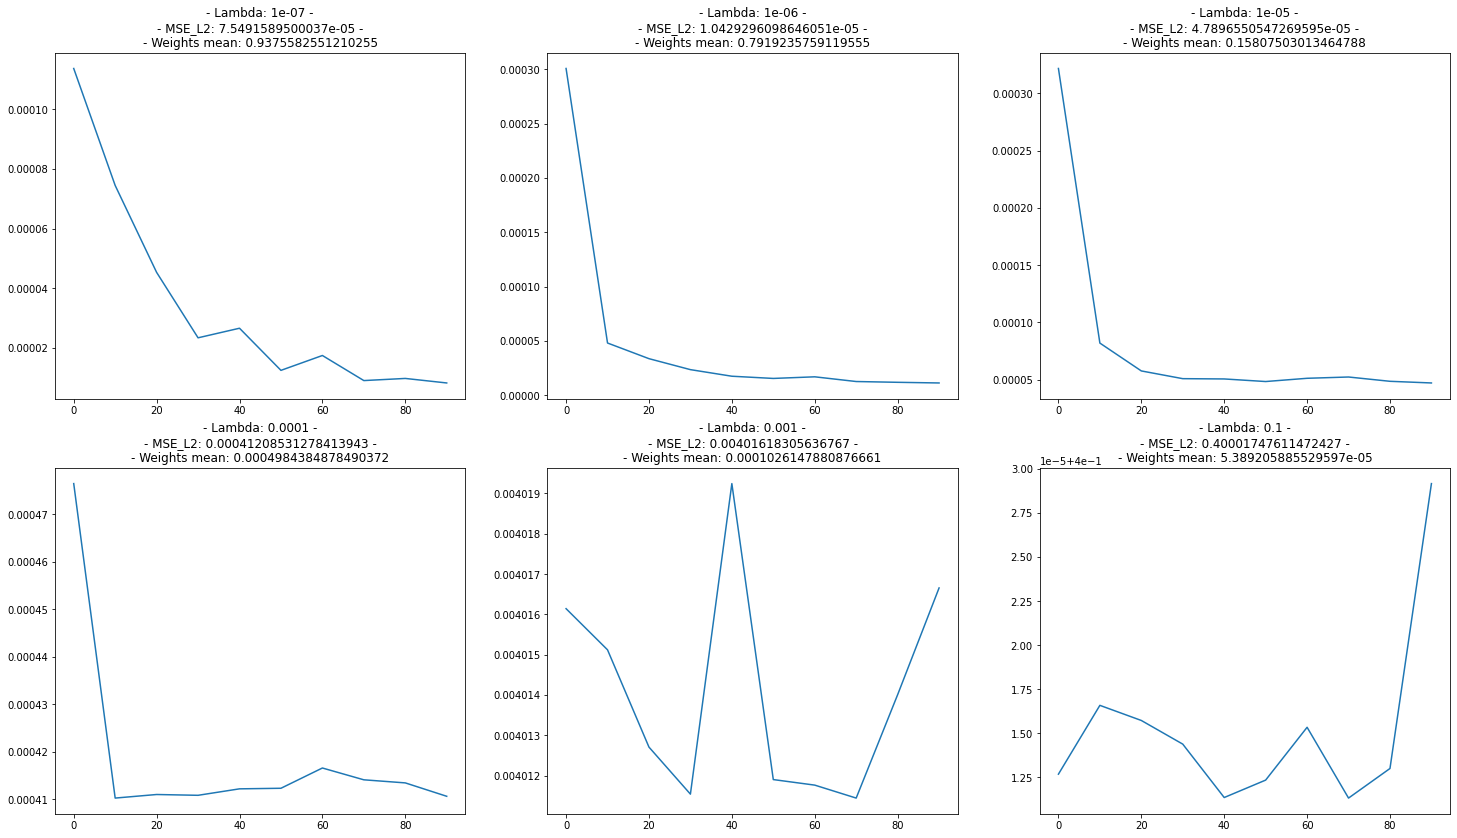

In [40]:
# Setting up training params
learning_rate = 0.7
batch_size = 12
lambda_vals = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.1]

## Learning rate training
fig, axs = plt.subplots(2, 3, figsize = (25, 14))
i,j = 0,0
best_lr = 0.01
for lambda_ in lambda_vals:
    final_weights, mse_l2_test, loss_history = train_and_evaluate(X2,y2,learning_rate,iterations,degree, lambda_, batch_size, print_loss = False)
    temp = np.arange(100, step = 10)
    axs[i][j].plot(temp, loss_history[0::10])
    axs[i][j].set_title("- Lambda: %s -\n- MSE_L2: %s -\n- Weights mean: %s" % (lambda_, mse_l2_test[0], final_weights.mean()))
    j+=1
    if j%3==0:
        i+=1
        j=0

#### By examining the regularization parameter, I can conclude that the best model result is achieved when the value of the parameter is less 1e-06

### Best model

Weights: [[-0.0100526   0.66054372  0.67547867  0.43068667  0.47057223  0.41393123
  -0.18429658  0.70081603  0.71920375  0.7125184   0.71307358  0.71187458
   0.71220124  0.71120796  0.69958764  0.71320854  0.71399471  0.71307189
   0.71193347  0.71216657  0.7121886   0.7046128   0.71330446  0.71389302
   0.6916295   0.69285819  0.71134819  0.70930343  0.71149282  0.71559583
   0.69367884  0.71161705  0.7086374   0.71176597  0.71531903  0.70107916
   0.68798037  0.71152601  0.71570524  0.04827462  0.70694613  0.7199893
   0.71347678  0.71371469  0.71357897  0.71359935  0.71361182  0.71360454
   0.71360892  0.71359683  0.71339556  0.71361366  0.71362937  0.71361564
   0.71361124  0.71361328  0.71360912  0.71348127  0.71361754  0.71362551
   0.71353032  0.71353653  0.71360384  0.7135632   0.71360876  0.71363383
   0.71354031  0.71360627  0.7135498   0.71361101  0.71363156  0.71353884
   0.71322331  0.71360467  0.71363847  0.70284384  0.71351707  0.71372122
   0.71361845  0.71362455  0.7

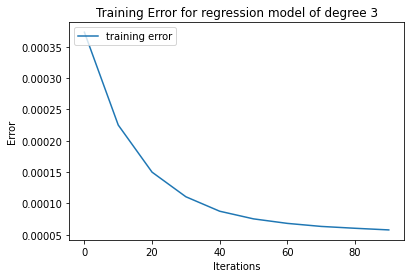

In [265]:
# Setting up training params
learning_rate = 0.7
iterations = 100
degree = 3
lambda_ = 0.00001
batch_size = 12
final_weights, mse_l2_test, loss_history = train_and_evaluate(X2,y2,learning_rate,iterations,degree, lambda_, batch_size)
plot_loss_curve_each_n_epochs(loss_history, 10)